In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation


Dx= 20
Lx= 6000/2
Dy= Dx
Ly= Lx
U= 3
V= 0
g= 9.8
H= 5
h_mtn = 0.25
w_xmtn = 100
w_ymtn = w_xmtn
x_0 = Lx/2
y_0 = Ly/2
T=400
K=25
coriolis_parameter = 1e-2
Nx = int(Lx/Dx)
Ny = int(Ly/Dy)

Dt = 0.5
n_plot = 1 

Diffusivity = "True" # Options: "True" or "False"
Nonlinear = "True" # If True, non-linear advection added
Coriolis = "True"
topography = "Ridge" 
plot_type = "Contour"

if topography == "Water_Pile": # Change surface height instead of bathymetry and start with no mean motion
    U = 0
    h_mtn = 0.025
    w_xmtn = 1e4
    w_ymtn = w_xmtn
    T=4e4
    K=2500
    H=5000
    Dx=2000
    Dy= Dx
    Lx=3e5
    Ly= Lx
    x_0 = Lx/2
    y_0 = Ly/2
    Nx = int(Lx/Dx)
    Ny = int(Ly/Dy)
    Dt = 50
    
n_plot = 1 

n_timesteps = T/Dt + 1

# Create grid
x_1D = np.arange(0,Lx,Dx)
y_1D = np.arange(0,Ly,Dy)

# Set initial condition
u = np.zeros([Nx, Ny, int(n_timesteps)])
v = np.zeros([Nx, Ny, int(n_timesteps)])
h = np.zeros([Nx, Ny, int(n_timesteps)])
h_s = np.zeros([Nx, Ny])
x = np.zeros([Nx, Ny])
y = np.zeros([Nx, Ny])
for y_step in range(Ny):
    x[:,y_step] = x_1D
for x_step in range(Nx):
    y[x_step,:] = y_1D
    
# Apply initial condition
u[:,:,0]=U
h[:,:,0]=H
v[:,:,0]=V

# Create seamount (note h-points are located Dx/2 ahead of u-points)
if topography == "Ridge":
    h_s = h_mtn*np.exp(- 0.5 * (x -x_0)**2. / w_xmtn**2 )
elif topography == "Mount":
    h_s = h_mtn*np.exp(- 0.5 *( ( (x -x_0)**2. / w_xmtn**2 ) + (y - y_0)**2. / w_ymtn**2 ) )
elif topography == "Partial_Ridge":
    h_s = h_mtn*np.exp(- 0.5 * (x -x_0)**2. / w_xmtn**2 ) *(1- np.exp(- 0.5 * (y -y_0)**2. / w_ymtn**2 ))
elif topography == "Water_Pile": # Change surface height instead of bathymetry and start with no mean motion
    h[:,:,0] = h_mtn*np.exp(- 0.5 *( ( (x -x_0)**2. / w_xmtn**2 ) + (y - y_0)**2. / w_ymtn**2 ) )



<IPython.core.display.Javascript object>


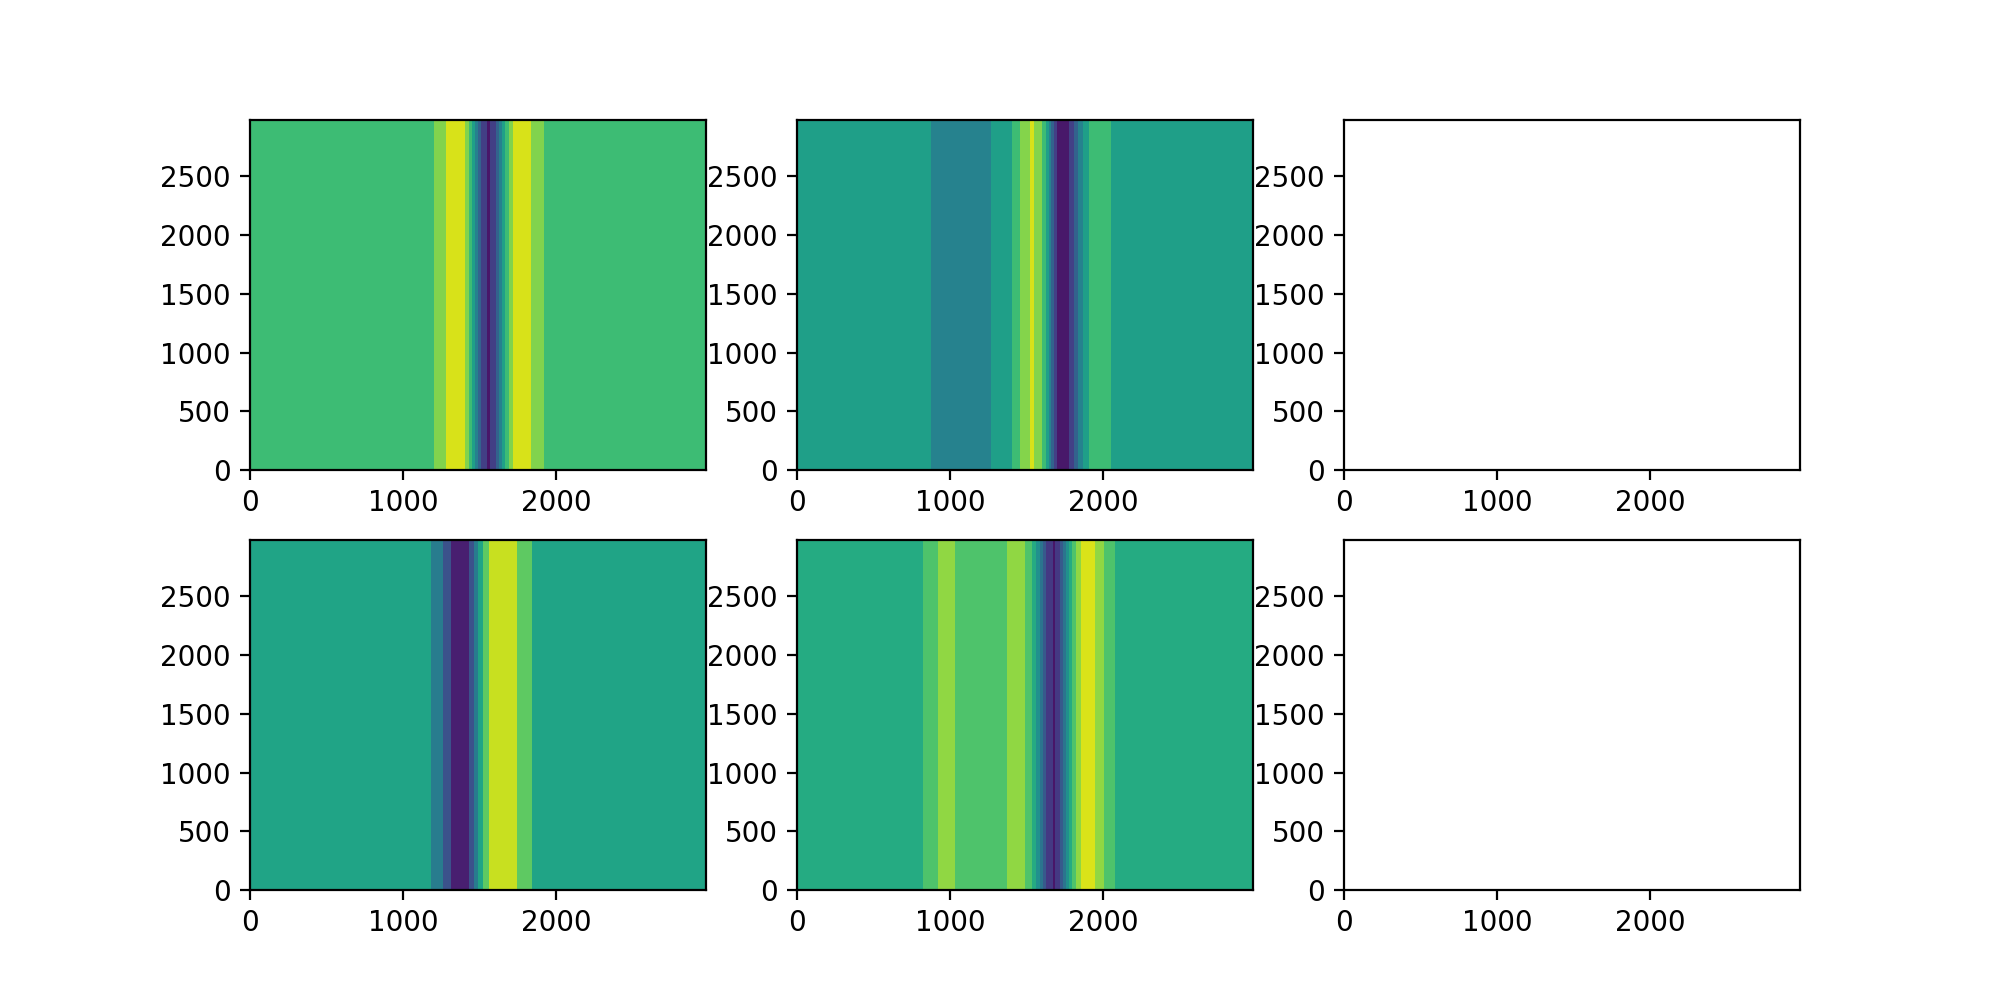

<ipython-input-2-e26de238ff97>:13: RuntimeWarning: overflow encountered in multiply
  uv = 0.5*( np.roll((u[:,:,time_step-1]),1,1) + u[:,:,time_step-1]
<ipython-input-2-e26de238ff97>:15: RuntimeWarning: overflow encountered in multiply
  uh = 0.5*( np.roll((u[:,:,time_step-1]),-1,0) + u[:,:,time_step-1] ) * (h[:,:,time_step-1] + h_s)
<ipython-input-2-e26de238ff97>:16: RuntimeWarning: overflow encountered in multiply
  vh = 0.5*( np.roll((v[:,:,time_step-1]),-1,1) + v[:,:,time_step-1] ) * (h[:,:,time_step-1] + h_s)
<ipython-input-2-e26de238ff97>:17: RuntimeWarning: overflow encountered in square
  u2 = u[:,:,time_step-1]**2
<ipython-input-2-e26de238ff97>:18: RuntimeWarning: overflow encountered in square
  v2 = v[:,:,time_step-1]**2
<ipython-input-2-e26de238ff97>:20: RuntimeWarning: invalid value encountered in subtract
  u[:,:,time_step] += - (Dt/(2*Dx))*(np.roll(u2,-1,0) - np.roll(u2,1,0))
<ipython-input-2-e26de238ff97>:21: RuntimeWarning: invalid value encountered in subtract
  u[:,:

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(2, 3)
xpos=0
ypos=0

for time_step in range(1,int(n_timesteps)):
    time = time_step*Dt
    
    # Uncentered/forward time - Centered space
    # Here we assume that points are aranged as h_{j-1} - u_{j} - h_{j} - u_{j+1} etc.
    
    if Nonlinear=="True": # use non-linear advection terms
        uv = 0.5*( np.roll((u[:,:,time_step-1]),1,1) + u[:,:,time_step-1] 
                 ) * 0.5 * ( np.roll((v[:,:,time_step-1]),1,0) + v[:,:,time_step-1] )
        uh = 0.5*( np.roll((u[:,:,time_step-1]),-1,0) + u[:,:,time_step-1] ) * (h[:,:,time_step-1] + h_s)
        vh = 0.5*( np.roll((v[:,:,time_step-1]),-1,1) + v[:,:,time_step-1] ) * (h[:,:,time_step-1] + h_s)
        u2 = u[:,:,time_step-1]**2
        v2 = v[:,:,time_step-1]**2
        u[:,:,time_step] = u[:,:,time_step-1] 
        u[:,:,time_step] += - (Dt/(2*Dx))*(np.roll(u2,-1,0) - np.roll(u2,1,0))
        u[:,:,time_step] += - (Dt/Dy)*(np.roll(uv,-1,1) - uv)
        u[:,:,time_step] += - (g*Dt/Dx)*(h[:,:,time_step-1] - np.roll(h[:,:,time_step-1],1,0))
        
        v[:,:,time_step] = v[:,:,time_step-1] 
        v[:,:,time_step] += - (Dt/(2*Dy))*(np.roll(v2,-1,1) - np.roll(v2,1,1))
        v[:,:,time_step] += - (Dt/Dx)*(np.roll(uv,-1,0) - uv)
        v[:,:,time_step] += - (g*Dt/Dy)*(h[:,:,time_step-1] - np.roll(h[:,:,time_step-1],1,1))
        
        h[:,:,time_step] = h[:,:,time_step-1] 
        h[:,:,time_step] += - (Dt/(2*Dx))*(np.roll(uh,-1,0) - np.roll(uh,1,0))
        h[:,:,time_step] += - (Dt/(2*Dy))*(np.roll(vh,-1,0) - np.roll(vh,1,0))
        
    else:
        u[:,:,time_step] = u[:,:,time_step-1] 
        u[:,:,time_step] += - (U*Dt/(2*Dx))*(np.roll(u[:,:,time_step-1],-1,0) - \
                                                         np.roll(u[:,:,time_step-1],1,0))
        u[:,:,time_step] += - (V*Dt/(2*Dy))*(np.roll(u[:,:,time_step-1],-1,1) - \
                                                         np.roll(u[:,:,time_step-1],1,1))
        u[:,:,time_step] += - (g*Dt/Dx)*(h[:,:,time_step-1] - \
                                                         np.roll(h[:,:,time_step-1],1,0))
        
        h[:,:,time_step] = h[:,:,time_step-1] 
        h[:,:,time_step] += - (U*Dt/(2*Dx))*( np.roll( (h[:,:,time_step-1]-h_s) ,-1,0) - \
                                                         np.roll( (h[:,:,time_step-1]-h_s) ,1,0))
        h[:,:,time_step] += - (V*Dt/(2*Dy))*( np.roll( (h[:,:,time_step-1]-h_s) ,-1,1) - \
                                                         np.roll( (h[:,:,time_step-1]-h_s) ,1,1))
        h[:,:,time_step] += - (H*Dt/Dx)*(np.roll(u[:,:,time_step-1],-1,0) - \
                                                         u[:,:,time_step-1])
        
        v[:,:,time_step] = v[:,:,time_step-1] 
        v[:,:,time_step] += - (U*Dt/(2*Dx))*(np.roll(v[:,:,time_step-1],-1,0) - \
                                                        np.roll(v[:,:,time_step-1],1,0))
        v[:,:,time_step] += - (V*Dt/(2*Dy))*(np.roll(v[:,:,time_step-1],-1,1) - \
                                                         np.roll(v[:,:,time_step-1],1,1))
        v[:,:,time_step] += - (g*Dt/Dy)*(h[:,:,time_step-1] - \
                                                         np.roll(h[:,:,time_step-1],1,1))
        
    if Diffusivity=="True": # Add diffusivity terms
        # x-derivatives
        u[:,:,time_step] += (K*Dt/(Dx**2))*(np.roll(u[:,:,time_step-1],-1,0) - 2*u[:,:,time_step-1] \
                                         + np.roll(u[:,:,time_step-1],1,0))
        v[:,:,time_step] += (K*Dt/(Dx**2))*(np.roll(v[:,:,time_step-1],-1,0) - 2*v[:,:,time_step-1] \
                                         + np.roll(v[:,:,time_step-1],1,0))
        h[:,:,time_step] += (K*Dt/(Dx**2))*(np.roll(h[:,:,time_step-1],-1,0) - 2*h[:,:,time_step-1] \
                                         + np.roll(h[:,:,time_step-1],1,0))
        # y-derivatives
        u[:,:,time_step] += (K*Dt/(Dy**2))*(np.roll(u[:,:,time_step-1],-1,1) - 2*u[:,:,time_step-1] \
                                         + np.roll(u[:,:,time_step-1],1,1))
        v[:,:,time_step] += (K*Dt/(Dy**2))*(np.roll(v[:,:,time_step-1],-1,1) - 2*v[:,:,time_step-1] \
                                         + np.roll(v[:,:,time_step-1],1,1))
        h[:,:,time_step] += (K*Dt/(Dy**2))*(np.roll(h[:,:,time_step-1],-1,1) - 2*h[:,:,time_step-1] \
                                         + np.roll(h[:,:,time_step-1],1,1))
    if Coriolis=="True": # Add Coriolis terms
        # x-derivatives
        u[:,:,time_step] += coriolis_parameter*v[:,:,time_step-1]
        v[:,:,time_step] += - coriolis_parameter*u[:,:,time_step-1]
    
    time_factor = 1
    if topography == "Water_Pile":
        time_factor = 100
            
        
    if (time==20*time_factor) or (time==100*time_factor) or (time==400*time_factor):
        if plot_type=="Line":
            axs[ypos,xpos].plot(x, u[:,0,time_step],'k-',label="Numerical u at t={}".format(time))
            axs[ypos,xpos].plot(x, u[:,0,0],'k:',label="Initial u".format(time))
            ypos=ypos+1
            axs[ypos,xpos].plot(x, h[:,0,time_step],'k-',label="Numerical h at t={}".format(time))
            axs[ypos,xpos].plot(x, h[:,0,0],'k:',label="Initial h".format(time))
            xpos = xpos+1
            ypos=ypos-1
        elif plot_type=="Contour":
            axs[ypos,xpos].contourf(x, y, u[:,:,time_step])
            #axs[ypos,xpos].colorbar()
            ypos=ypos+1
            axs[ypos,xpos].contourf(x, y, h[:,:,time_step])
            xpos = xpos+1
            ypos=ypos-1
        
        
plt.show()

<IPython.core.display.Javascript object>


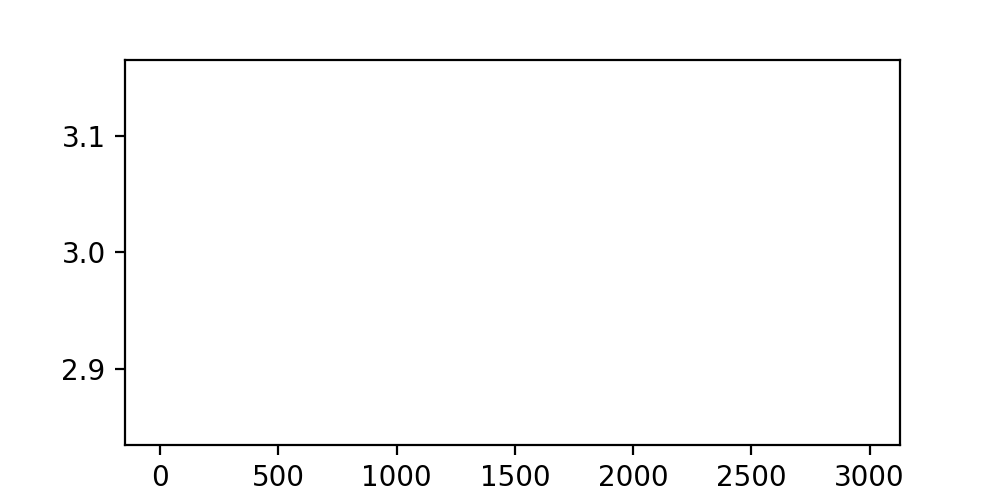

In [3]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()

line, = ax.plot(x[:,0], u[:,int(Ny/2),0])

def animate(i):
    line.set_ydata(u[:,int(Ny/2),i])  # update the data.
    return line,

ani = animation.FuncAnimation(
    fig, animate, frames=2000, interval=1, save_count=200)
plt.show()

<IPython.core.display.Javascript object>


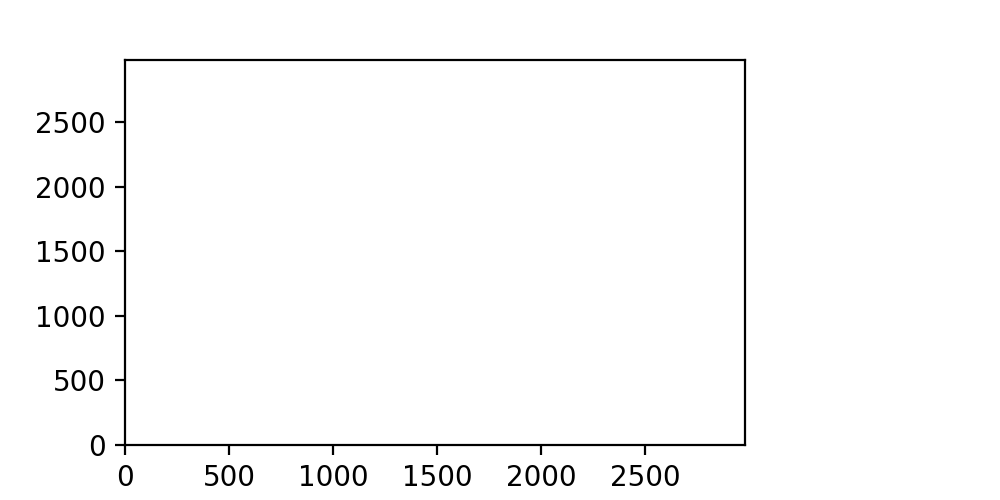

/Users/brodiepearson/opt/miniconda3/lib/python3.8/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/brodiepearson/opt/miniconda3/lib/python3.8/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


<function matplotlib.pyplot.show(block=None)>

In [4]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
plt.contourf(x, y, h[:,:,-1], vmax=H+np.max(abs(h-H)), vmin=H-np.max(abs(h-H)), cmap='seismic')
            
plt.colorbar()
plt.show

<IPython.core.display.Javascript object>


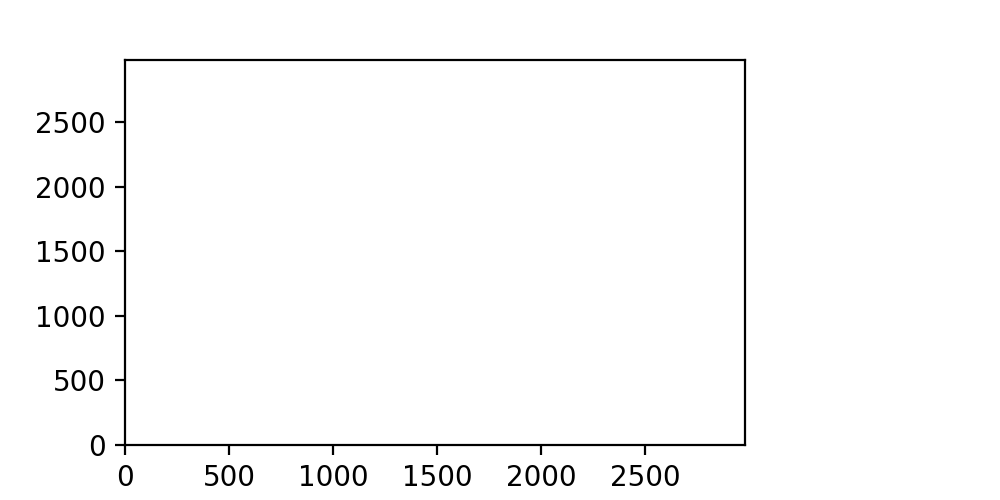

<function matplotlib.pyplot.show(block=None)>

In [5]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
plt.contourf(x, y, u[:,:,-1], vmax=U+np.max(abs(u-U)), vmin=U-np.max(abs(u-U)), cmap='seismic')
            
plt.colorbar()
plt.show

<IPython.core.display.Javascript object>


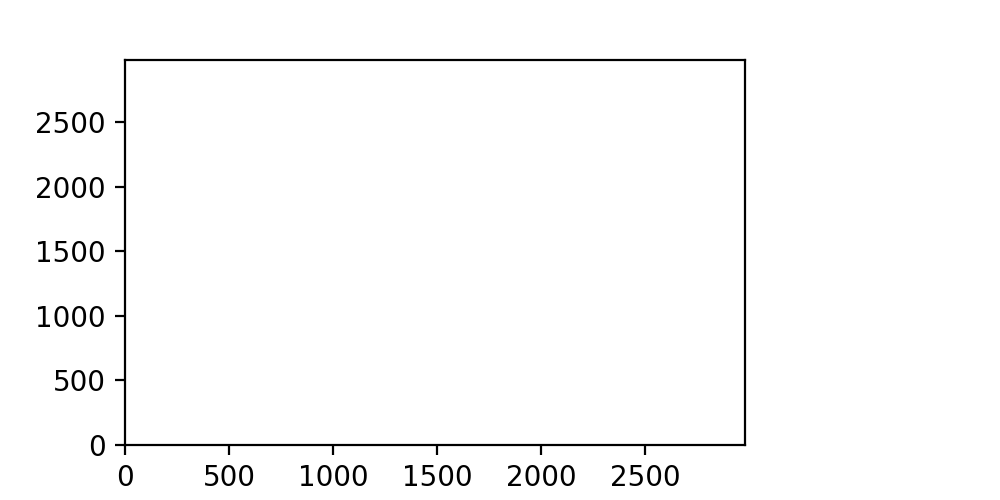

<function matplotlib.pyplot.show(block=None)>

In [6]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
plt.contourf(x, y, v[:,:,-100], vmax=V+np.max(abs(v-V)), vmin=V-np.max(abs(v-V)), cmap='seismic')
            
plt.colorbar()
plt.show

In [7]:
x.shape, y.shape, u.shape, v.shape,u[:,:,-1].shape, y[0,:].shape

((150, 150), (150, 150), (150, 150, 801), (150, 150, 801), (150, 150), (150,))

<IPython.core.display.Javascript object>


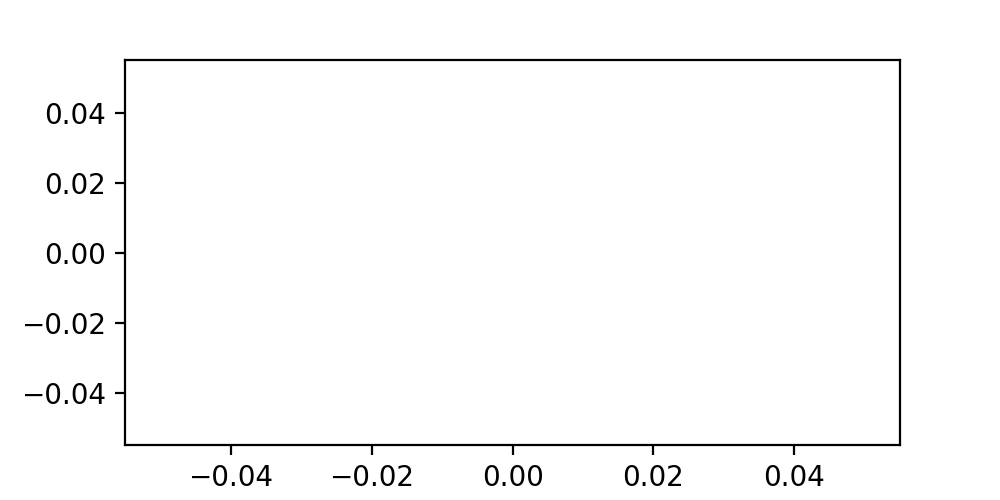

<function matplotlib.pyplot.show(block=None)>

In [8]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
# plt.streamplot(y[0,:],x[:,0], v[:,:,-1], u[:,:,-1])
plt.streamplot(x[:,0],y[0,:], np.transpose(u[:,:,-1]), np.transpose(v[:,:,-1]))         
plt.show

<IPython.core.display.Javascript object>


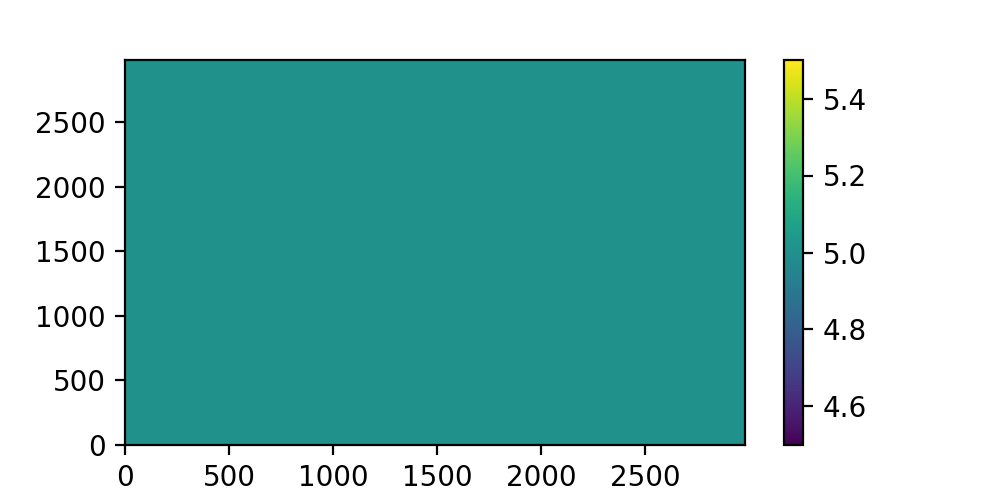

<ipython-input-9-35aa307b9e32>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x,y,h[:,:,0])


<function matplotlib.pyplot.show(block=None)>

In [9]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
plt.pcolor(x,y,h[:,:,0])
plt.colorbar()
plt.show

In [10]:
u2 = u[:,:,0]**2
u2

array([[9., 9., 9., ..., 9., 9., 9.],
       [9., 9., 9., ..., 9., 9., 9.],
       [9., 9., 9., ..., 9., 9., 9.],
       ...,
       [9., 9., 9., ..., 9., 9., 9.],
       [9., 9., 9., ..., 9., 9., 9.],
       [9., 9., 9., ..., 9., 9., 9.]])